In [108]:
import cv2
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import random

In [109]:

img_dir = '/data112/MIDOG2022/images/'
save__dir = '/data112/MIDOG2022/patches/'
json_path = '/data112/wzy/MIDOG2022/mmdetection-2.25.0/annotations/training.json'


size = 512
step = 512

In [110]:
with open(json_path, 'r') as json_file:
	coco = json.load(json_file)

In [111]:
# 获取注释和图片的数量
ann = coco["annotations"]
num_ann = len(ann)

img = coco["images"]
num_img = len(img)

In [112]:
def scanner_label(i):
    i += 1
    if(1<=i<=150):
        label = "unknown"
    elif(150 <= i <= 194):
        label = "3DHistech Pannoramic Scan II"
    elif(195 <= i <= 249):
        label = "3DHistech Pannoramic Scan II"
    elif(250 <= i <= 299):
        label = "Aperio ScanScope CS2"
    elif(300 <= i <= 354):
        label = "Hamamatsu NanoZoomer XR"
    elif(354 <= i <= 404):
        label = "Hamamatsu NanoZoomer XR"
    else:
        label = "unknown"
    return label

In [113]:
def cancer_label(i):
    i += 1
    if(1<=i<=150):
        label = "breast"
    elif(150 <= i <= 194):
        label = "lung"
    elif(195 <= i <= 249):
        label = "lymphoma"
    elif(250 <= i <= 299):
        label = "mast celll tumor"
    elif(300 <= i <= 354):
        label = "paostate"
    elif(354 <= i <= 404):
        label = "melanoma"
    else:
        label = "unknown"
    return label

In [114]:

patch_coco = dict()
patch_img = [] 
patch_ann = []
cnt_img = 0     # patch的id
cnt_bbox = 0    # 注释的id
for i,info in enumerate(img):
    # 读图
    print(i)
    id = info["file_name"]
    pic  = cv2.imread(img_dir+id)
    print(pic.shape)
    width = pic.shape[1]
    height = pic.shape[0]
    # 读取出该张图片对应的bbox和对应的类别
    bbox = []
    cat = []
    for j in range(num_ann):
        if(ann[j]["image_id"] == info["id"]):
            bbox.append(ann[j]["bbox"])
            cat.append(ann[j]["category_id"])

    # 先根据bbox的位置采样
    for k in range(len(bbox)):
        box = bbox[k]
        cnt_img += 1
        cnt_bbox += 1
        # 获得bbox的左上角坐标(cx,cy)
        cx = int(box[0])
        cy = int(box[1])
        cx = max(cx,0)
        cy = max(cy,0)

        
        # 在生成的512*512的patch中，使样本细胞处于中间位置,且不超出区域外
        # 生成的patch的左上角坐标(x1,y1)
        x1 = max(cx-231,0)
        y1 = max(cy-231,0)
        x1 = min(x1,width-size)
        y1 = min(y1,height-size)
        # print(cx,cy)
        # print(x1,y1)
        tile = pic[y1:y1+512,x1:x1+512]
        # tile = cv2.rectangle(tile,(int(cx-x1), int(cy-y1)), (int(cx-x1+50), int(cy-y1+50)),(0, 0, 0), 2)
        patch_img.append({"license": 1, "file_name":  '{}_{}_{}.png'.format(i+1,cx,cy), "id": cnt_img, "width": 512, "height": 512})
        patch_ann.append({"iscrowd" : 0, "area" : 2500, "bbox": [cx-x1, cy-y1, 50, 50], "category_id": cat[k], "image_id": cnt_img, "id": cnt_bbox,"scanner_id":scanner_label(i),"tumor_label":cancer_label(i)})
        
        #检查图片中是否还存在样本
        for cell in bbox:
            xx = int(box[0])
            yy = int(box[1])
            if(x1 <= xx <= x1+512 and y1 <= yy <= y1+512 and cx != xx):
                cnt_bbox += 1
                patch_ann.append({"iscrowd" : 0, "area" : 2500, "bbox": [cx-xx, cy-yy, 50, 50], "category_id": cat[k], "image_id": cnt_img, "id": cnt_bbox,"scanner_id":scanner_label(i),"tumor_label":cancer_label(i)})
                
        cv2.imwrite(save__dir + '{}_{}_{}.png'.format(i+1,cx,cy),tile)


    # 再做一次随机的采样
    for k in range(len(bbox)):
        flag = 1

        while(flag == 1):
            x1 = random.randint(0,width-size)
            y1 = random.randint(0,height-size)
            for cell in bbox:
                xx = int(box[0])
                yy = int(box[1])
                if(xx > x1+512 or xx < x1-50 or y1 > y1+512 or y1 < y1-50): flag = 0
        cnt_img += 1
        tile = pic[y1:y1+512,x1:x1+512]
        # tile = cv2.rectangle(tile,(int(cx-x1), int(cy-y1)), (int(cx-x1+50), int(cy-y1+50)),(0, 0, 0), 2)
        patch_img.append({"license": 1, "file_name":  '{}_{}_{}_empty.png'.format(i+1,x1,y1), "id": cnt_img, "width": 512, "height": 512})
        cv2.imwrite(save__dir + '{}_{}_{}_empty.png'.format(i+1,x1,y1),tile)


0
(5412, 7215, 3)
4336 346
4105 115
(5412, 7215, 3)
(512, 512, 3)
756 872
525 641
(5412, 7215, 3)
(512, 512, 3)
270 4044
39 3813
(5412, 7215, 3)
(512, 512, 3)
6672 706
6441 475
(5412, 7215, 3)
(512, 512, 3)
1
(5412, 7215, 3)
1872 319
1641 88
(5412, 7215, 3)
(512, 512, 3)
4397 191
4166 0
(5412, 7215, 3)
(512, 512, 3)
1842 1558
1611 1327
(5412, 7215, 3)
(512, 512, 3)
3783 2346
3552 2115
(5412, 7215, 3)
(512, 512, 3)
5319 3252
5088 3021
(5412, 7215, 3)
(512, 512, 3)
6242 3193
6011 2962
(5412, 7215, 3)
(512, 512, 3)
7045 3791
6703 3560
(5412, 7215, 3)
(512, 512, 3)
4450 4059
4219 3828
(5412, 7215, 3)
(512, 512, 3)
4636 4294
4405 4063
(5412, 7215, 3)
(512, 512, 3)
1306 4912
1075 4681
(5412, 7215, 3)
(512, 512, 3)
4341 5213
4110 4900
(5412, 7215, 3)
(512, 512, 3)
3683 5245
3452 4900
(5412, 7215, 3)
(512, 512, 3)
1291 2758
1060 2527
(5412, 7215, 3)
(512, 512, 3)
3506 2461
3275 2230
(5412, 7215, 3)
(512, 512, 3)
4582 2336
4351 2105
(5412, 7215, 3)
(512, 512, 3)
2172 3232
1941 3001
(5412, 7215,

In [115]:
patch_coco.update({"info": {"description": "MItosis Domain Generalization Challenge (MIDOG) 2022 - Training set", "version": "1.0", "year": 2022, "contributor": "Marc Aubreville, Christof Bertram, Mitko Veta, Robert Klopfleisch, Nikolas Stathonikos, Samir Jabari, Taryn Donovan, Katharina Breininger", "date_created": "2022/05/13"}, "licenses": [{"url": "http://creativecommons.org/licenses/by-nc-nd/2.0/", "id": 1, "name": "Attribution-NonCommercial-NoDerivs License"}]})
patch_coco.update({"images":patch_img})
patch_coco.update({"categories": [{"id": 0, "name": "mitotic figure"}, {"id": 1, "name": "not mitotic figure"}]})
patch_coco.update({"annotations":patch_ann})

In [78]:
patch_coco

{'info': {'description': 'MItosis Domain Generalization Challenge (MIDOG) 2022 - Training set',
  'version': '1.0',
  'year': 2022,
  'contributor': 'Marc Aubreville, Christof Bertram, Mitko Veta, Robert Klopfleisch, Nikolas Stathonikos, Samir Jabari, Taryn Donovan, Katharina Breininger',
  'date_created': '2022/05/13'},
 'licenses': [{'url': 'http://creativecommons.org/licenses/by-nc-nd/2.0/',
   'id': 1,
   'name': 'Attribution-NonCommercial-NoDerivs License'}],
 'images': [{'license': 1,
   'file_name': '1_4336_346.png',
   'id': 1,
   'width': 512,
   'height': 512},
  {'license': 1,
   'file_name': '1_756_872.png',
   'id': 2,
   'width': 512,
   'height': 512},
  {'license': 1,
   'file_name': '1_270_4044.png',
   'id': 3,
   'width': 512,
   'height': 512},
  {'license': 1,
   'file_name': '1_6672_706.png',
   'id': 4,
   'width': 512,
   'height': 512},
  {'license': 1,
   'file_name': '1_5283_1645_empty.png',
   'id': 5,
   'width': 512,
   'height': 512},
  {'license': 1,
   

In [116]:

file = '/data112/wzy/MIDOG2022/mycode/patch_testing.json'
data = json.dumps(patch_coco,indent=1)
with open(file,'w',encoding='utf-8',newline='\n') as f:
    f.write(data)
    print("加载入文件完成...")

加载入文件完成...


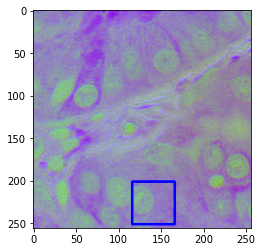

In [35]:
tile = cv2.rectangle(tile,(116,201), (166, 251),(0, 0, 255), 2)
plt.imshow(tile)